# Spark processing

## 1. Libraries and Spark setup

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window

In [ ]:
print('user:', os.environ['JUPYTERHUB_SERVICE_PREFIX'])

def uiWebUrl(self):
    from urllib.parse import urlparse
    web_url = self._jsc.sc().uiWebUrl().get()
    port = urlparse(web_url).port
    return '{}proxy/{}/jobs/'.format(os.environ['JUPYTERHUB_SERVICE_PREFIX'], port)

SparkContext.uiWebUrl = property(uiWebUrl)

conf = SparkConf()
conf.set('spark.master', 'local[*]')
conf.set('spark.driver.memory', '40G')
conf.set('spark.driver.maxResultSize', '40G')
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
spark

In [4]:
def access_data(file_path):
    with open(file_path) as file:
        access_data = json.load(file)
    return access_data

access_s3_data = access_data('.access_jhub_data')

In [5]:
spark._jsc.hadoopConfiguration().set('fs.s3a.access.key', access_s3_data['aws_access_key_id'])
spark._jsc.hadoopConfiguration().set('fs.s3a.secret.key', access_s3_data['aws_secret_access_key'])
spark._jsc.hadoopConfiguration().set('fs.s3a.impl','org.apache.hadoop.fs.s3a.S3AFileSystem')
spark._jsc.hadoopConfiguration().set('fs.s3a.multipart.size', '104857600')
spark._jsc.hadoopConfiguration().set('fs.s3a.block.size', '33554432')
spark._jsc.hadoopConfiguration().set('fs.s3a.threads.max', '256')
spark._jsc.hadoopConfiguration().set('fs.s3a.endpoint', 'http://storage.yandexcloud.net')
spark._jsc.hadoopConfiguration().set('fs.s3a.aws.credentials.provider', 
                                     'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')

## 2. Data load

In [6]:
BUCKET = 'pvc-84ea79a0-dc20-4a2d-86ab-f83c1f8d4a7b'

In [7]:
files_path = 'data/events'
#files_mask = f'{files_path}/*.csv' # all the data
files_mask = f'{files_path}/data_2024-05-*.csv' # test part of data
sdf = spark.read.option('escape','"').csv(f's3a://{BUCKET}/{files_mask}', header=True)

In [8]:
sdf.printSchema()

root
 |-- event_datetime: string (nullable = true)
 |-- event_json: string (nullable = true)
 |-- event_name: string (nullable = true)
 |-- event_receive_datetime: string (nullable = true)
 |-- event_receive_timestamp: string (nullable = true)
 |-- event_timestamp: string (nullable = true)
 |-- session_id: string (nullable = true)
 |-- installation_id: string (nullable = true)
 |-- appmetrica_device_id: string (nullable = true)
 |-- city: string (nullable = true)
 |-- connection_type: string (nullable = true)
 |-- country_iso_code: string (nullable = true)
 |-- device_ipv6: string (nullable = true)
 |-- device_locale: string (nullable = true)
 |-- device_manufacturer: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- google_aid: string (nullable = true)
 |-- ios_ifa: string (nullable = true)
 |-- ios_ifv: string (nullable = true)
 |-- mcc: string (nullable = true)
 |-- mnc: string (nullable = true)
 |-- operator_name: s

In [9]:
sdf = sdf.withColumn("event_datetime", F.to_timestamp("event_datetime"))

In [10]:
sdf.count()

46745893

In [ ]:
sdf.limit(5).toPandas()

## 3. EDA

### 3.1. Users and devices

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
print('Columns overview')
pd.DataFrame(sdf.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,event_datetime,timestamp
1,event_json,string
2,event_name,string
3,event_receive_datetime,string
4,event_receive_timestamp,string
5,event_timestamp,string
6,session_id,string
7,installation_id,string
8,appmetrica_device_id,string
9,city,string


In [ ]:
# Cast event_name to lower so that its easier to use filters 
sdf = sdf.withColumn('event_name_lower', F.lower(F.col('event_name')))

# Create a new column with '/' replaced by ' ' in 'event_name'
sdf = sdf.withColumn('event_name_modified', F.regexp_replace('event_name_lower', '/', ' '))

sdf.limit(5).toPandas()



## Analysis by city

In [15]:
sdf.groupBy('city').count().show()

+------------------+-------+
|              city|  count|
+------------------+-------+
|         Volgograd|  96085|
|          Voronezh| 143938|
|           Bryansk|  59313|
|        Sevastopol|  68385|
|              Omsk|  94503|
|          Belgorod|  48614|
|       Makhachkala| 219902|
|         Togliatti|  41947|
|        Domodedovo|  14862|
|           Lipetsk|  45619|
|Naberezhnie Chelny|  26971|
|           Labinsk|    276|
|             Istra|  21189|
|            Moscow|6126081|
|          Kaspiysk|  19183|
|         Stavropol| 374077|
|     Yekaterinburg| 579764|
|            Krymsk|   3638|
|            Berlin|   8318|
|         Krasnodar| 833043|
+------------------+-------+
only showing top 20 rows



In [16]:
# Предполагается, что df - это DataFrame, содержащий столбец 'city'.
unique_cities = sdf.select("city").distinct().count()
print(unique_cities)


1767


In [38]:
# Предполагается, что df - это DataFrame, содержащий столбец 'city'.
unique_cities = sdf_with_user_payments.select("city").distinct().count()
print(unique_cities)


1102


In [17]:
import pyspark.sql.functions as F

sdf.groupBy("city").agg(F.countDistinct("profile_id")).show(10)


+---------+-----------------+
|     city|count(profile_id)|
+---------+-----------------+
|Volgograd|             3064|
|    Topki|               25|
| Horlivka|               16|
|    Mainz|               33|
|   Svetly|               14|
|  Hanover|                1|
|  Bryansk|             2168|
| Voronezh|             4381|
|     Ruza|              120|
|   Volhov|               38|
+---------+-----------------+
only showing top 10 rows



In [18]:
import pyspark.sql.functions as F
sdf.groupBy("city").agg(F.countDistinct("profile_id").alias("count")).orderBy(F.col("count").asc()).show(12)

+------------+-----+
|        city|count|
+------------+-----+
|       Kinel|    0|
|     Chifeng|    0|
|    Kambarka|    0|
|     Netanya|    0|
|        Tara|    0|
|    Salzburg|    0|
|     Jiamusi|    0|
|  Nonthaburi|    0|
|    Kuvandik|    0|
| Alessandria|    0|
|   Khyrdalan|    0|
|Nizhny Lomov|    0|
+------------+-----+
only showing top 12 rows



In [18]:
import pyspark.sql.functions as F
sdf.groupBy("city").agg(F.countDistinct("profile_id").alias("count")).orderBy(F.col("count").desc()).limit(5).toPandas()

,city,count
0,None,531050
1,Moscow,164331
2,Saint Petersburg,37197
3,Krasnodar,25346
4,Yekaterinburg,19497


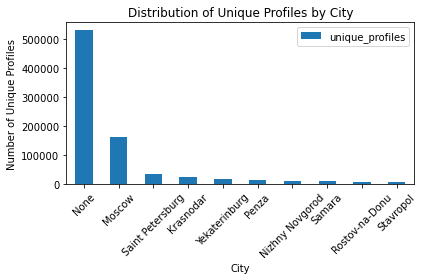

In [19]:
# Create a bar chart of the unique profile counts
sdf.groupBy("city").agg(F.countDistinct("profile_id").alias("unique_profiles")).sort("unique_profiles", ascending=False).limit(10).toPandas().plot.bar(x="city", y="unique_profiles")
plt.xlabel("City")
plt.ylabel("Number of Unique Profiles")
plt.title("Distribution of Unique Profiles by City")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

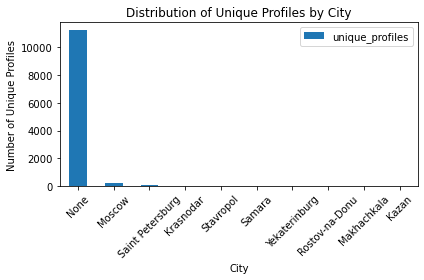

In [44]:
# Create a bar chart of the unique profile counts
sdf_with_user_payments.groupBy("city").agg(F.countDistinct("profile_id").alias("unique_profiles")).sort("unique_profiles", ascending=False).limit(10).toPandas().plot.bar(x="city", y="unique_profiles")
plt.xlabel("City")
plt.ylabel("Number of Unique Profiles")
plt.title("Distribution of Unique Profiles by City")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
import pyspark.sql.functions as F
sdf.groupBy("city").agg(F.countDistinct("profile_id").alias("count")).orderBy(F.col("count").desc()).limit(10).toPandas()

,city,count
0,None,531050
1,Moscow,164331
2,Saint Petersburg,37197
3,Krasnodar,25346
4,Yekaterinburg,19497
5,Penza,16157
6,Nizhny Novgorod,12853
7,Samara,10380
8,Rostov-na-Donu,9529
9,Stavropol,9524


In [45]:
import pyspark.sql.functions as F
sdf_with_user_payments.groupBy("city").agg(F.countDistinct("profile_id").alias("count")).orderBy(F.col("count").desc()).limit(10).toPandas()

,city,count
0,None,11215
1,Moscow,217
2,Saint Petersburg,56
3,Krasnodar,46
4,Stavropol,15
5,Samara,14
6,Yekaterinburg,14
7,Rostov-na-Donu,12
8,Makhachkala,11
9,Kazan,10


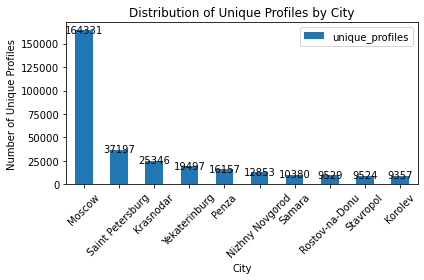

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Создайте столбчатую диаграмму уникальных профилей
df = sdf.groupBy("city").agg(F.countDistinct("profile_id").alias("unique_profiles"))
df_sorted = df.sort("unique_profiles", ascending=False).limit(11).dropna().toPandas()
df_sorted.plot.bar(x="city", y="unique_profiles")

# Добавьте подписи к столбцам
for bar in plt.gca().patches:
    plt.gca().annotate(format(bar.get_height(), '.0f'),
                     (bar.get_x() + bar.get_width() / 2,
                      bar.get_height()), ha='center', va='center')

# Настройте диаграмму
plt.xlabel("City")
plt.ylabel("Number of Unique Profiles")
plt.title("Distribution of Unique Profiles by City")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

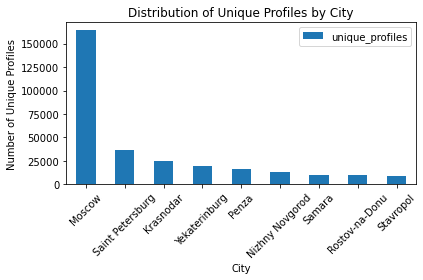

In [22]:
# Create a bar chart of the unique profile counts
sdf.groupBy("city").agg(F.countDistinct("profile_id").alias("unique_profiles")).sort("unique_profiles", ascending=False).limit(10).dropna().toPandas().plot.bar(x="city", y="unique_profiles")
plt.xlabel("City")
plt.ylabel("Number of Unique Profiles")
plt.title("Distribution of Unique Profiles by City")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

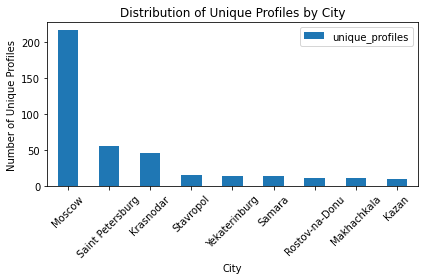

In [47]:
# Create a bar chart of the unique profile counts
sdf_with_user_payments.groupBy("city").agg(F.countDistinct("profile_id").alias("unique_profiles")).sort("unique_profiles", ascending=False).limit(10).dropna().toPandas().plot.bar(x="city", y="unique_profiles")
plt.xlabel("City")
plt.ylabel("Number of Unique Profiles")
plt.title("Distribution of Unique Profiles by City")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Analysis by type of connection

In [23]:
# Предполагается, что df - это DataFrame, содержащий столбец 'city'.
unique_ct = sdf.select("connection_type").distinct().count()
print(unique_ct)


3


In [24]:
import pyspark.sql.functions as F
sdf.groupBy("connection_type").agg(F.countDistinct("profile_id").alias("count")).orderBy(F.col("count").desc()).toPandas()

,connection_type,count
0,cell,558792
1,wifi,212864
2,unknown,618


In [48]:
import pyspark.sql.functions as F
sdf_with_user_payments.groupBy("connection_type").agg(F.countDistinct("profile_id").alias("count")).orderBy(F.col("count").desc()).toPandas()

,connection_type,count
0,cell,11560
1,wifi,10


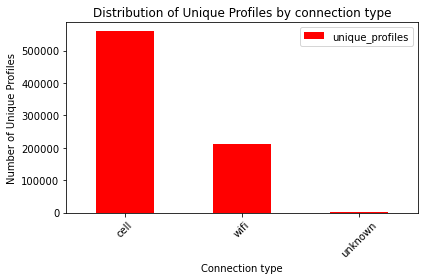

In [25]:
# Create a bar chart of the unique profile counts
sdf.groupBy("connection_type").agg(F.countDistinct("profile_id").alias("unique_profiles")).sort("unique_profiles", ascending=False).toPandas().plot.bar(x="connection_type", y="unique_profiles", color='red')
plt.xlabel("Connection type")
plt.ylabel("Number of Unique Profiles")
plt.title("Distribution of Unique Profiles by connection type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

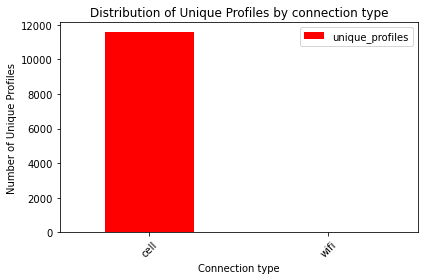

In [49]:
# Create a bar chart of the unique profile counts
sdf_with_user_payments.groupBy("connection_type").agg(F.countDistinct("profile_id").alias("unique_profiles")).sort("unique_profiles", ascending=False).toPandas().plot.bar(x="connection_type", y="unique_profiles", color='red')
plt.xlabel("Connection type")
plt.ylabel("Number of Unique Profiles")
plt.title("Distribution of Unique Profiles by connection type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

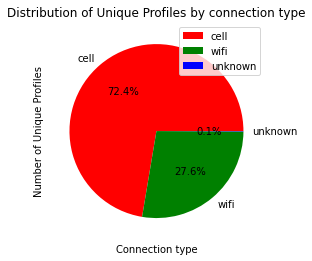

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame with the unique profile counts
df = sdf.groupBy("connection_type").agg(F.countDistinct("profile_id").alias("unique_profiles")).sort("unique_profiles", ascending=False).toPandas()

# Create a pie chart
df.plot.pie(x="connection_type", y="unique_profiles", autopct='%1.1f%%', colors=['red', 'green', 'blue'], labels=['cell', 'wifi', 'unknown'])

# Add labels and title
plt.xlabel("Connection type")
plt.ylabel("Number of Unique Profiles")
plt.title("Distribution of Unique Profiles by connection type")

# Show the plot
plt.show()

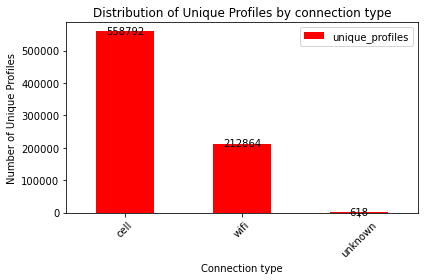

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Создайте столбчатую диаграмму уникальных профилей
df = sdf.groupBy("connection_type").agg(F.countDistinct("profile_id").alias("unique_profiles"))
df_sorted = df.sort("unique_profiles", ascending=False).limit(11).dropna().toPandas()
df_sorted.plot.bar(x="connection_type", y="unique_profiles", color='red')

# Добавьте подписи к столбцам
for bar in plt.gca().patches:
    plt.gca().annotate(format(bar.get_height(), '.0f'),
                     (bar.get_x() + bar.get_width() / 2,
                      bar.get_height()), ha='center', va='center')

# Настройте диаграмму
plt.xlabel("Connection type")
plt.ylabel("Number of Unique Profiles")
plt.title("Distribution of Unique Profiles by connection type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Analysis by ISO Country codes

In [28]:
# Предполагается, что df - это DataFrame, содержащий столбец 'city'.
unique_ct = sdf.select("country_iso_code").distinct().count()
print(unique_ct)


137


In [29]:
import pyspark.sql.functions as F
sdf.groupBy("country_iso_code").agg(F.countDistinct("profile_id").alias("count")).orderBy(F.col("count").desc()).limit(15).toPandas()

,country_iso_code,count
0,RU,609735
1,FR,5090
2,DE,4702
3,NL,4454
4,None,2710
5,GB,2634
6,US,1950
7,TR,1878
8,BY,1121
9,KZ,846


In [50]:
import pyspark.sql.functions as F
sdf_with_user_payments.groupBy("country_iso_code").agg(F.countDistinct("profile_id").alias("count")).orderBy(F.col("count").desc()).limit(15).toPandas()

,country_iso_code,count
0,RU,11301
1,DE,88
2,NL,50
3,None,38
4,US,34
5,FR,34
6,GB,27
7,AZ,16
8,FI,13
9,TR,11


In [52]:
import pyspark.sql.functions as F
sdf_with_user_payments.groupBy("country_iso_code").agg(F.countDistinct("profile_id").alias("count")).orderBy(F.col("count").desc()).limit(15).dropna().toPandas()

,country_iso_code,count
0,RU,11301
1,DE,88
2,NL,50
3,US,34
4,FR,34
5,GB,27
6,AZ,16
7,FI,13
8,TH,11
9,TR,11


In [30]:
import pyspark.sql.functions as F
sdf.groupBy("country_iso_code").agg(F.countDistinct("profile_id").alias("count")).orderBy(F.col("count").asc()).limit(15).toPandas()

,country_iso_code,count
0,LC,1
1,PG,1
2,YE,1
3,AD,1
4,GQ,1
5,CF,1
6,PS,1
7,PA,1
8,PY,1
9,MK,1


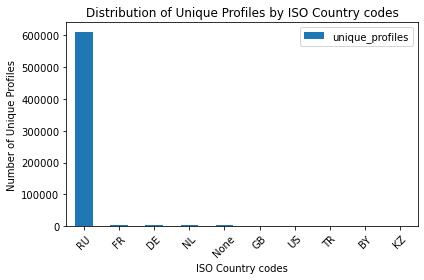

In [31]:
# Create a bar chart of the unique profile counts
sdf.groupBy("country_iso_code").agg(F.countDistinct("profile_id").alias("unique_profiles")).sort("unique_profiles", ascending=False).limit(10).toPandas().plot.bar(x="country_iso_code", y="unique_profiles")
plt.xlabel("ISO Country codes")
plt.ylabel("Number of Unique Profiles")
plt.title("Distribution of Unique Profiles by ISO Country codes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

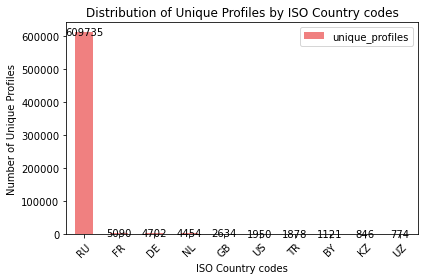

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Создайте столбчатую диаграмму уникальных профилей
df = sdf.groupBy("country_iso_code").agg(F.countDistinct("profile_id").alias("unique_profiles"))
df_sorted = df.sort("unique_profiles", ascending=False).limit(11).dropna().toPandas()
df_sorted.plot.bar(x="country_iso_code", y="unique_profiles", color='lightcoral')

# Добавьте подписи к столбцам
for bar in plt.gca().patches:
    plt.gca().annotate(format(bar.get_height(), '.0f'),
                     (bar.get_x() + bar.get_width() / 2,
                      bar.get_height()), ha='center', va='center')

# Настройте диаграмму
plt.xlabel("ISO Country codes")
plt.ylabel("Number of Unique Profiles")
plt.title("Distribution of Unique Profiles by ISO Country codes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Analysis by device manufacturer

In [33]:
# Предполагается, что df - это DataFrame, содержащий столбец 'city'.
unique_ct = sdf.select("device_manufacturer").distinct().count()
print(unique_ct)


220


In [53]:
# Предполагается, что df - это DataFrame, содержащий столбец 'city'.
unique_ct = sdf_with_user_payments.select("device_manufacturer").distinct().count()
print(unique_ct)


1


In [34]:
import pyspark.sql.functions as F
sdf.groupBy("device_manufacturer").agg(F.countDistinct("profile_id").alias("count")).orderBy(F.col("count").desc()).limit(15).toPandas()

,device_manufacturer,count
0,Apple,234906
1,Samsung,121821
2,Redmi,72616
3,Huawei,49047
4,Xiaomi,34911
5,Realme,24730
6,POCO,17700
7,Tecno,12959
8,Honor,10373
9,Infinix,9002


In [56]:
import pyspark.sql.functions as F
sdf_with_user_payments.groupBy("device_manufacturer").agg(F.countDistinct("profile_id").alias("count")).orderBy(F.col("count").desc()).toPandas()

,device_manufacturer,count
0,Apple,11570


In [35]:
import pyspark.sql.functions as F
sdf.groupBy("device_manufacturer").agg(F.countDistinct("profile_id").alias("count")).orderBy(F.col("count").asc()).limit(15).toPandas()

,device_manufacturer,count
0,THL,0
1,Explay,0
2,YTX,0
3,Yota Devices Limited,0
4,UNISOC,0
5,C20pro,0
6,Android,0
7,Hot Pepper,0
8,AllView,0
9,Doro,0


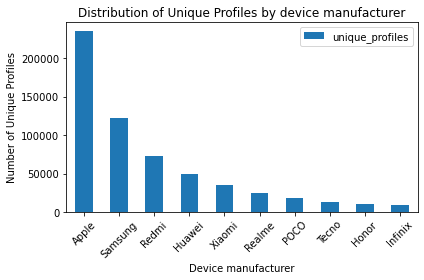

In [36]:
# Create a bar chart of the unique profile counts
sdf.groupBy("device_manufacturer").agg(F.countDistinct("profile_id").alias("unique_profiles")).sort("unique_profiles", ascending=False).limit(10).toPandas().plot.bar(x="device_manufacturer", y="unique_profiles")
plt.xlabel("Device manufacturer")
plt.ylabel("Number of Unique Profiles")
plt.title("Distribution of Unique Profiles by device manufacturer")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

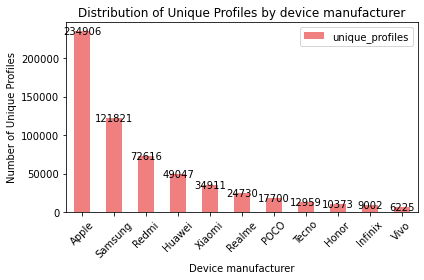

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Создайте столбчатую диаграмму уникальных профилей
df = sdf.groupBy("device_manufacturer").agg(F.countDistinct("profile_id").alias("unique_profiles"))
df_sorted = df.sort("unique_profiles", ascending=False).limit(11).dropna().toPandas()
df_sorted.plot.bar(x="device_manufacturer", y="unique_profiles", color='lightcoral')

# Добавьте подписи к столбцам
for bar in plt.gca().patches:
    plt.gca().annotate(format(bar.get_height(), '.0f'),
                     (bar.get_x() + bar.get_width() / 2,
                      bar.get_height()), ha='center', va='center')

# Настройте диаграмму
plt.xlabel("Device manufacturer")
plt.ylabel("Number of Unique Profiles")
plt.title("Distribution of Unique Profiles by device manufacturer")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Analysis by device model 

In [38]:
# Предполагается, что df - это DataFrame, содержащий столбец 'city'.
unique_ct = sdf.select("device_model").distinct().count()
print(unique_ct)


3275


In [39]:
import pyspark.sql.functions as F
sdf.groupBy("device_model").agg(F.countDistinct("profile_id").alias("count")).orderBy(F.col("count").desc()).limit(25).toPandas()

,device_model,count
0,iPhone 11,36474
1,iPhone 13,16287
2,iPhone 12,13303
3,iPhone XR,13181
4,iPhone 13 Pro Max,11849
5,iPhone 13 Pro,11660
6,iPhone 14 Pro Max,11579
7,iPhone 14 Pro,10781
8,"iPhone16,2",10612
9,"iPhone16,1",8472


In [57]:
import pyspark.sql.functions as F
sdf_with_user_payments.groupBy("device_model").agg(F.countDistinct("profile_id").alias("count")).orderBy(F.col("count").desc()).limit(25).toPandas()

,device_model,count
0,iPhone 11,1721
1,iPhone 14 Pro Max,765
2,iPhone 13,716
3,iPhone 14 Pro,713
4,iPhone 13 Pro Max,674
5,iPhone XR,608
6,iPhone 13 Pro,599
7,iPhone 12,565
8,"iPhone16,2",535
9,iPhone 12 Pro,465


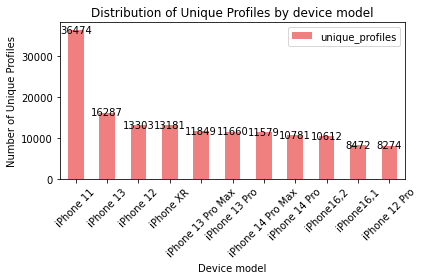

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Создайте столбчатую диаграмму уникальных профилей
df = sdf.groupBy("device_model").agg(F.countDistinct("profile_id").alias("unique_profiles"))
df_sorted = df.sort("unique_profiles", ascending=False).limit(11).dropna().toPandas()
df_sorted.plot.bar(x="device_model", y="unique_profiles", color='lightcoral')

# Добавьте подписи к столбцам
for bar in plt.gca().patches:
    plt.gca().annotate(format(bar.get_height(), '.0f'),
                     (bar.get_x() + bar.get_width() / 2,
                      bar.get_height()), ha='center', va='center')

# Настройте диаграмму
plt.xlabel("Device model")
plt.ylabel("Number of Unique Profiles")
plt.title("Distribution of Unique Profiles by device model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

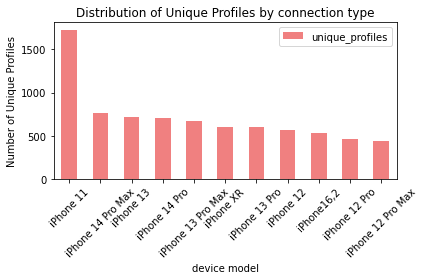

In [60]:
# Create a bar chart of the unique profile counts
sdf_with_user_payments.groupBy("device_model").agg(F.countDistinct("profile_id").alias("unique_profiles")).sort("unique_profiles", ascending=False).limit(11).toPandas().plot.bar(x="device_model", y="unique_profiles", color='lightcoral')
plt.xlabel("device model")
plt.ylabel("Number of Unique Profiles")
plt.title("Distribution of Unique Profiles by connection type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Analysis by device type 

In [41]:
# Предполагается, что df - это DataFrame, содержащий столбец 'city'.
unique_ct = sdf.select("device_type").distinct().count()
print(unique_ct)


2


In [42]:
import pyspark.sql.functions as F
sdf.groupBy("device_type").agg(F.countDistinct("profile_id").alias("count")).orderBy(F.col("count").desc()).toPandas()

,device_type,count
0,phone,612785
1,tablet,5529


In [61]:
import pyspark.sql.functions as F
sdf_with_user_payments.groupBy("device_type").agg(F.countDistinct("profile_id").alias("count")).orderBy(F.col("count").desc()).toPandas()

,device_type,count
0,phone,11533
1,tablet,37


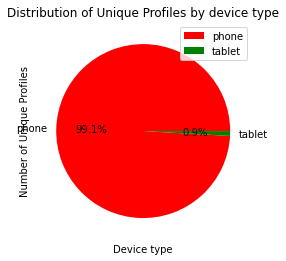

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame with the unique profile counts
df = sdf.groupBy("device_type").agg(F.countDistinct("profile_id").alias("unique_profiles")).sort("unique_profiles", ascending=False).toPandas()

# Create a pie chart
df.plot.pie(x="device_type", y="unique_profiles", autopct='%1.1f%%', colors=['red', 'green'], labels=['phone', 'tablet'])

# Add labels and title
plt.xlabel("Device type")
plt.ylabel("Number of Unique Profiles")
plt.title("Distribution of Unique Profiles by device type")

# Show the plot
plt.show()

## Analysis by device os name

In [44]:
# Предполагается, что df - это DataFrame, содержащий столбец 'city'.
unique_ct = sdf.select("os_name").distinct().count()
print(unique_ct)


2


In [45]:
import pyspark.sql.functions as F
sdf.groupBy("os_name").agg(F.countDistinct("profile_id").alias("count")).orderBy(F.col("count").desc()).toPandas()

,os_name,count
0,android,383220
1,ios,234906


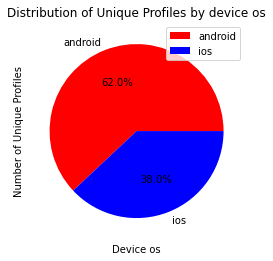

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame with the unique profile counts
df = sdf.groupBy("os_name").agg(F.countDistinct("profile_id").alias("unique_profiles")).sort("unique_profiles", ascending=False).toPandas()

# Create a pie chart
df.plot.pie(x="os_name", y="unique_profiles", autopct='%1.1f%%', colors=['red', 'blue'], labels=['android', 'ios'])

# Add labels and title
plt.xlabel("Device os")
plt.ylabel("Number of Unique Profiles")
plt.title("Distribution of Unique Profiles by device os")

# Show the plot
plt.show()

## Analysis by operator_name

In [47]:
# Предполагается, что df - это DataFrame, содержащий столбец 'city'.
unique_ct = sdf.select("operator_name").distinct().count()
print(unique_ct)


1205


In [48]:
import pyspark.sql.functions as F
sdf.groupBy("operator_name").agg(F.countDistinct("profile_id").alias("count")).orderBy(F.col("count").desc()).limit(15).toPandas()

,operator_name,count
0,None,258940
1,MTS RUS,109382
2,Tele2,67277
3,Beeline,62542
4,MegaFon,60968
5,beeline,28416
6,MegaFon #1,22717
7,МТС,19930
8,YOTA,15201
9,MegaFon pre-5G,4973


In [62]:
import pyspark.sql.functions as F
sdf_with_user_payments.groupBy("operator_name").agg(F.countDistinct("profile_id").alias("count")).orderBy(F.col("count").desc()).limit(15).toPandas()

,operator_name,count
0,None,11542
1,Mobile TeleSystems,10
2,MegaFon,9
3,Beeline,4
4,Tele2,2
5,Carrier,2
6,YOTA,1


In [49]:
import pyspark.sql.functions as F
sdf.groupBy("operator_name").agg(F.countDistinct("profile_id").alias("count")).orderBy(F.col("count").asc()).limit(15).toPandas()

,operator_name,count
0,Ooredoo TN,0
1,DEFACE,0
2,BL4CKOV,0
3,Ikrom7,0
4,CMAPTC-GSM,0
5,SVK 777,0
6,Izhevskiy,0
7,Movistar,0
8,Zaebisa,0
9,4emaKinG,0


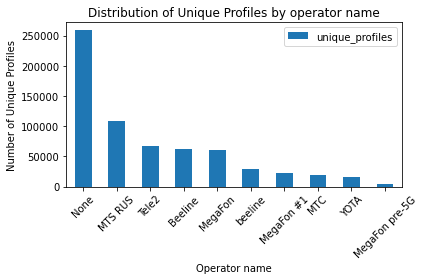

In [50]:
# Create a bar chart of the unique profile counts
sdf.groupBy("operator_name").agg(F.countDistinct("profile_id").alias("unique_profiles")).sort("unique_profiles", ascending=False).limit(10).toPandas().plot.bar(x="operator_name", y="unique_profiles")
plt.xlabel("Operator name")
plt.ylabel("Number of Unique Profiles")
plt.title("Distribution of Unique Profiles by operator name")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

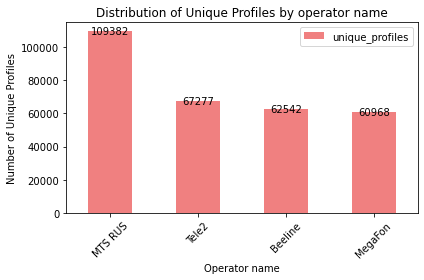

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Создайте столбчатую диаграмму уникальных профилей
df = sdf.groupBy("operator_name").agg(F.countDistinct("profile_id").alias("unique_profiles"))
df_sorted = df.sort("unique_profiles", ascending=False).limit(5).dropna().toPandas()
df_sorted.plot.bar(x="operator_name", y="unique_profiles", color='lightcoral')

# Добавьте подписи к столбцам
for bar in plt.gca().patches:
    plt.gca().annotate(format(bar.get_height(), '.0f'),
                     (bar.get_x() + bar.get_width() / 2,
                      bar.get_height()), ha='center', va='center')

# Настройте диаграмму
plt.xlabel("Operator name")
plt.ylabel("Number of Unique Profiles")
plt.title("Distribution of Unique Profiles by operator name")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Count of users who paid and did not pay in March
# Keywords that indicate a payment
payment_keywords = ["завершили оплату", "платёж принят"]

# Filter users based on payment keywords
users_paid_totall = sdf.filter(
    F.col('event_name_modified').contains(payment_keywords[0]) | 
    F.col('event_name_modified').contains(payment_keywords[1]) 
)

users_paid_totall.limit(1).toPandas()


In [53]:
# Count of users who match the payment keywords
paid_count_total = users_paid_totall.select('profile_id').distinct().count()

print(f"Number of users who paid in all data based on keywords: {paid_count_total}")

Number of users who paid in all data based on keywords: 28452


In [54]:
import seaborn as sns

# Подсчет количества оплат для каждого пользователя
payment_counts = sdf.filter(
    (F.col('event_name').like('%{}%'.format(payment_keywords[0])) |
     F.col('event_name').like('%{}%'.format(payment_keywords[1])))
).groupBy('profile_id').count()

# Преобразование результатов в Pandas DataFrame для удобства работы с данными
payment_counts_df = payment_counts.toPandas()

In [55]:
sdf.select('profile_id').distinct().count()

618127

In [56]:
sdf.select('appmetrica_device_id').distinct().count()

632294

In [57]:
#checking that all event name columns have full data 

sdf.filter(F.col('event_name').isNull()).count()

0

In [58]:
#checking that all profile_id columns have full data 

sdf.filter(F.col('profile_id').isNull()).count()

458957

In [59]:
sdf = sdf.filter("profile_id IS NOT NULL")


In [ ]:
sdf.show(1)

Chek 2 cells before

In [ ]:
# Cast event_name to lower so that its easier to use filters 
sdf = sdf.withColumn('event_name_lower', F.lower(F.col('event_name')))

# Create a new column with '/' replaced by ' ' in 'event_name'
sdf = sdf.withColumn('event_name_modified', F.regexp_replace('event_name_lower', '/', ' '))

sdf.limit(5).toPandas()



In [31]:
sdf.printSchema()

root
 |-- event_datetime: timestamp (nullable = true)
 |-- event_json: string (nullable = true)
 |-- event_name: string (nullable = true)
 |-- event_receive_datetime: string (nullable = true)
 |-- event_receive_timestamp: string (nullable = true)
 |-- event_timestamp: string (nullable = true)
 |-- session_id: string (nullable = true)
 |-- installation_id: string (nullable = true)
 |-- appmetrica_device_id: string (nullable = true)
 |-- city: string (nullable = true)
 |-- connection_type: string (nullable = true)
 |-- country_iso_code: string (nullable = true)
 |-- device_ipv6: string (nullable = true)
 |-- device_locale: string (nullable = true)
 |-- device_manufacturer: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- google_aid: string (nullable = true)
 |-- ios_ifa: string (nullable = true)
 |-- ios_ifv: string (nullable = true)
 |-- mcc: string (nullable = true)
 |-- mnc: string (nullable = true)
 |-- operator_name

In [ ]:
# Cast 'event_datetime' to a timestamp type
sdf = sdf.withColumn('event_datetime', F.to_timestamp(F.col('event_datetime')))

# Filter for users who were active in March 2023
users_in_march_df = sdf.filter(F.month('event_datetime') == 3) \
                                    .filter(F.year('event_datetime') == 2024)


users_in_march_df.limit(5).toPandas()


In [ ]:
# Cast 'event_datetime' to a timestamp type
sdf = sdf.withColumn('event_datetime', F.to_timestamp(F.col('event_datetime')))

# Filter for users who were active in march 2024
#sdf = sdf.filter(F.month('event_datetime') == 3) \
#                                    .filter(F.year('event_datetime') == 2024)


sdf.limit(2).toPandas()


In [ ]:
# Count of users who paid and did not pay in March
# Keywords that indicate a payment
payment_keywords = ["завершили оплату", "завешили оплату", "платёж принят"]

# Filter users based on payment keywords
users_paid_march = users_in_march_df.filter(
    F.col('event_name_modified').contains(payment_keywords[0]) | 
    F.col('event_name_modified').contains(payment_keywords[1]) |
    F.col('event_name_modified').contains(payment_keywords[2])
)

users_paid_march.limit(5).toPandas()


In [64]:
# Находим самую раннюю дату
earliest_date = sdf.agg(F.min("event_datetime")).first()[0]

# Находим самую позднюю дату
latest_date = sdf.agg(F.max("event_datetime")).first()[0]

print(f"Самая ранняя дата: {earliest_date}")
print(f"Самая поздняя дата: {latest_date}")


Самая ранняя дата: 2024-05-01 00:00:00
Самая поздняя дата: 2024-05-31 23:59:59


In [ ]:
# Count of users who paid and did not pay in March
# Keywords that indicate a payment
payment_keywords = ["завершили оплату", "платёж принят"]

# Filter users based on payment keywords
users_paid_totall = sdf.filter(
    F.col('event_name_modified').contains(payment_keywords[0]) | 
    F.col('event_name_modified').contains(payment_keywords[1]) 
)

users_paid_totall.limit(5).toPandas()


In [ ]:
import matplotlib.pyplot as plt

# Предположим, у нас есть столбец 'value' в нашем датафрейме sdf
histogram_data = sdf.select('profile_id').toPandas()

# Создаем гистограмму
plt.hist(histogram_data['profile_id'], bins=20)
plt.title('Histogram of profile_id')
plt.xlabel('profile_id')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Count of users who paid and did not pay in March
payment_keywords = ["завершили оплату", "платёж принят"]

# Фильтрация пользователей на основе ключевых слов оплаты
users_paid_total = sdf.filter(
    F.col('event_name').like('%{}%'.format(payment_keywords[0])) |
    F.col('event_name').like('%{}%'.format(payment_keywords[1]))
)

# Подсчет количества оплат для каждого пользователя
payment_counts = users_paid_total.groupBy('profile_id').count()

In [66]:
null_counts = sdf.agg(*[F.count(F.when(F.col(c).isNull(), 1)).alias(c) for c in sdf.columns])


In [67]:
null_counts.toPandas().T


,0
event_datetime,0
event_json,28973847
event_name,0
event_receive_datetime,0
event_receive_timestamp,0
event_timestamp,0
session_id,0
installation_id,0
appmetrica_device_id,0
city,29627161


In [ ]:
import pyspark.sql.functions as F

# Подсчитываем количество нулевых значений в каждом столбце
null_counts = sdf.agg(*[F.count(F.when(F.col(c).isNull(), 1)).alias(c) for c in sdf.columns])
plt.figure(figsize=(90, 60))

# Визуализируем количество нулевых значений с помощью столбчатой диаграммы
null_counts.toPandas().plot.bar()
plt.xlabel("Column")
plt.ylabel("Number of null values")
plt.title("Number of Null Values per Column")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Увеличиваем размер холста графика
plt.figure(figsize=(15, 100))

# Визуализируем количество нулевых значений с помощью столбчатой диаграммы
null_counts.toPandas().plot.bar()
plt.xlabel("Column")
plt.ylabel("Number of null values")
plt.title("Number of Null Values per Column")
plt.xticks(rotation=90)

# Располагаем легенду вне области графика
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [68]:
# Count of users who match the payment keywords
paid_count_total = users_paid_totall.select('profile_id').distinct().count()

print(f"Number of users who paid in all data based on keywords: {paid_count_total}")

Number of users who paid in all data based on keywords: 28451


In [ ]:
import seaborn as sns

# Группировка данных по столбцу 'profile_id' и подсчет количества действий
action_distribution = sdf.groupBy('profile_id').agg(F.count('event_name').alias('action_count'))

# Преобразование результатов в Pandas DataFrame для удобства работы с данными
action_distribution_df = action_distribution.toPandas()

# Построение диаграммы размаха распределения количества действий по пользователям
plt.figure(figsize=(10, 6))
sns.boxplot(y=action_distribution_df['action_count'], color='skyblue')
plt.ylabel('Количество действий')
plt.title('Распределение количества действий по пользователям')
plt.grid(True)
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Группировка данных по столбцу 'profile_id' и подсчет количества действий
action_distribution = sdf.groupby('profile_id').count().reset_index()
action_distribution.columns = ['profile_id', 'action_count']

# Создание гистограммы
ax = sns.barplot(x="profile_id", y="action_count", data=action_distribution)
plt.title('Распределение количества действий по пользователям')
plt.show()


In [ ]:
# Удалить строки со значениями None
sdf = sdf[sdf['profile_id'].notnull()]

# Создать гистограмму
histogram_data = sdf.select('profile_id').toPandas()
plt.hist(histogram_data['profile_id'], bins=20)
plt.title('Histogram of profile_id')
plt.xlabel('profile_id')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# compare to total number of users in March 

total_users_march = users_in_march_df.select('profile_id').distinct().count()

print(f"Number of users who used the app in March: {total_users_march}")

In [ ]:
# how many payments did users make in March (i.e. what was the average number of payments a user made) 
payment_keywords = ["завершили оплату", "платёж принят"]

# Create a column that flags when a payment action was made 
# (this will help identify number of payment actions, as well as users who made a payment) 

users_in_march_df = users_in_march_df.withColumn(
    'made_payment',
    F.when(
        F.col('event_name_modified').contains(payment_keywords[0]) |
        F.col('event_name_modified').contains(payment_keywords[1]), 
        1
    ).otherwise(0)
)

users_in_march_df.limit(5).toPandas()


In [40]:
# Count of users who match the payment keywords
paid_count_march = users_paid_march.select('profile_id').distinct().count()

print(f"Number of users who paid in March 2024 based on keywords: {paid_count_march}")

Number of users who paid in March 2024 based on keywords: 25815


In [33]:
# compare to total number of users in 2023 

total_users_march = users_in_march_df.select('profile_id').distinct().count()

print(f"Number of users who used the app in March: {total_users_march}")

Number of users who used the app in March: 613281


In [ ]:
# how many payments did users make in March (i.e. what was the average number of payments a user made) 

# Create a column that flags when a payment action was made 
# (this will help identify number of payment actions, as well as users who made a payment) 

users_in_march_df = users_in_march_df.withColumn(
    'made_payment',
    F.when(
        F.col('event_name_modified').contains(payment_keywords[0]) |
        F.col('event_name_modified').contains(payment_keywords[1]),
        1
    ).otherwise(0)
)

users_in_march_df.limit(5).toPandas()


In [ ]:
users_in_march_df.limit(1).toPandas()


In [ ]:
#Создаем DataFrame с информацией о пользователях, совершивших хотя бы одну оплату
users_with_payments = users_in_march_df.filter(users_in_march_df.made_payment == 1).select("profile_id").distinct()
# Присоединяем информацию о пользователях, совершивших хотя бы одну оплату, к исходному DataFrame
sdf_with_user_payments = users_in_march_df.join(users_with_payments, "profile_id", "left")
# Добавляем новый столбец, который помечает строки, где пользователи когда-либо совершили хотя бы одну оплату
sdf_with_user_payments = sdf_with_user_payments.withColumn("user_made_payment",
                     F.when(sdf_with_user_payments.profile_id.isNotNull(), 1).otherwise(0))
# Отображаем данные, помеченные соответствующим образом
sdf_with_user_payments.limit(5).toPandas()


In [42]:
sdf_with_user_payments = sdf_with_user_payments.filter(sdf_with_user_payments.made_payment == 1)

In [ ]:
sdf_with_user_payments.limit(1).toPandas()


In [43]:
# Sum the made_payment flags for each user
payments_per_user_df = users_in_march_df.groupBy('profile_id').agg(F.sum('made_payment').alias('total_payments'))

# Calculate the average number of payments across all users
avg_payments_per_user = payments_per_user_df.agg(F.avg('total_payments')).collect()[0][0]

print(f"Average number of payments per user in March: {avg_payments_per_user}")

Average number of payments per user in March: 0.07366129663448996


In [44]:
# Filter out users who did not make any payments
paying_users_df = payments_per_user_df.filter(payments_per_user_df['total_payments'] > 0)

# Calculate the average number of payments for users who made at least one payment
avg_payments_per_paying_user = paying_users_df.agg(F.avg('total_payments')).collect()[0][0]

print(f"Average number of payments per paying user in March: {avg_payments_per_paying_user}")

Average number of payments per paying user in March: 1.7499515785396087


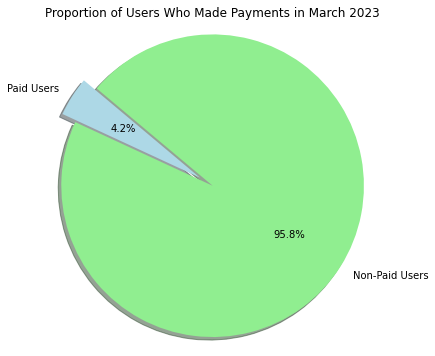

In [45]:
# Calculating the proportion
paid_proportion = (paid_count_march / total_users_march) * 100
non_paid_proportion = 100 - paid_proportion


# Data to plot
labels = 'Paid Users', 'Non-Paid Users'
sizes = [paid_proportion, non_paid_proportion]
colors = ['lightblue', 'lightgreen']
explode = (0.1, 0)  # explode the 1st slice for emphasis

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

plt.title('Proportion of Users Who Made Payments in March 2023')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.show()

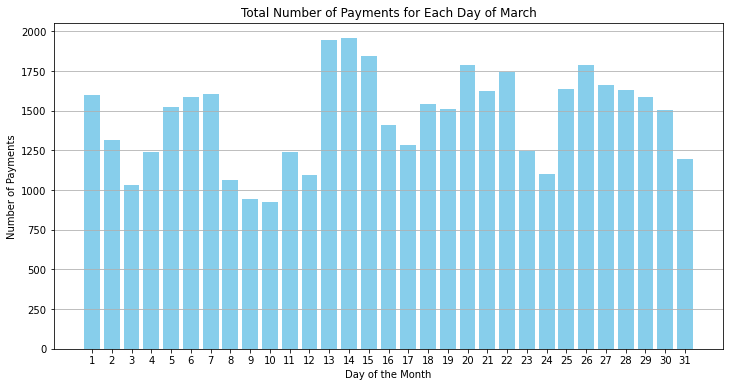

In [46]:
# Extract day from event_datetime
users_in_march_df = users_in_march_df.withColumn('day_of_month', F.dayofmonth('event_datetime'))

# Filter for payment actions and count per day
daily_payments_df = users_in_march_df.filter(F.col('made_payment') == 1).groupBy('day_of_month').count()

# Collect the result for visualization
daily_payments_pd = daily_payments_df.toPandas()
daily_payments_pd.sort_values('day_of_month', inplace=True)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(daily_payments_pd['day_of_month'], daily_payments_pd['count'], color='skyblue')
plt.xlabel('Day of the Month')
plt.ylabel('Number of Payments')
plt.title('Total Number of Payments for Each Day of March')
plt.xticks(range(1, 32))  # Assuming up to 31 days in a month
plt.grid(axis='y')
plt.show()

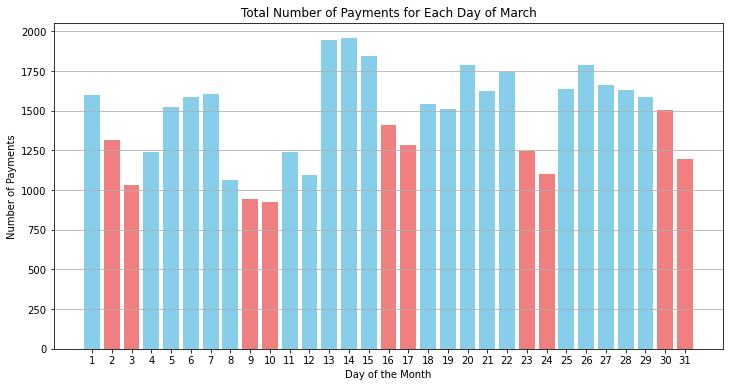

In [47]:
import calendar
import matplotlib.pyplot as plt

# Create a Pandas dataframe to use with matplotlib
daily_payments_pd = daily_payments_df.toPandas()
daily_payments_pd.sort_values('day_of_month', inplace=True)

# Get the list of weekend days in March 2024
weekend_days = [2, 3, 9, 10, 16, 17, 23, 24, 30, 31]

# Plotting with weekends highlighted
plt.figure(figsize=(12, 6))
bar_colors = ['skyblue' if day not in weekend_days else 'lightcoral' for day in daily_payments_pd['day_of_month']]
plt.bar(daily_payments_pd['day_of_month'], daily_payments_pd['count'], color=bar_colors)
plt.xlabel('Day of the Month')
plt.ylabel('Number of Payments')
plt.title('Total Number of Payments for Each Day of March')
plt.xticks(range(1, 32))  # Assuming up to 31 days in a month
plt.grid(axis='y')
plt.show()

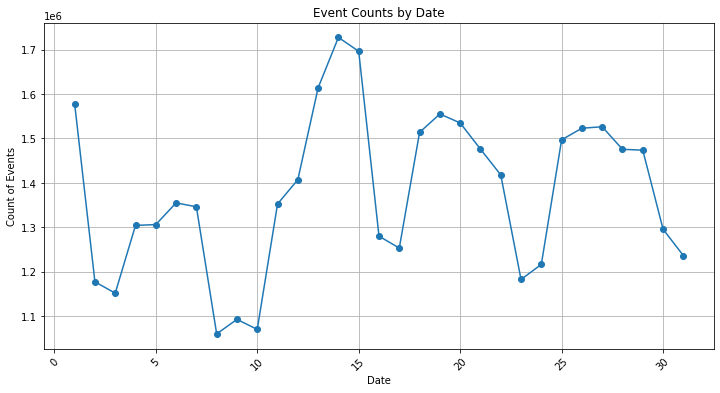

In [48]:
# Group by date and count the occurrences
events_count_by_day_df = users_in_march_df.groupBy('day_of_month').count()

# Collect the data for visualization
events_count_by_day_pd = events_count_by_day_df.toPandas()
events_count_by_day_pd.sort_values('day_of_month', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(events_count_by_day_pd['day_of_month'], events_count_by_day_pd['count'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Count of Events')
plt.title('Event Counts by Date')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

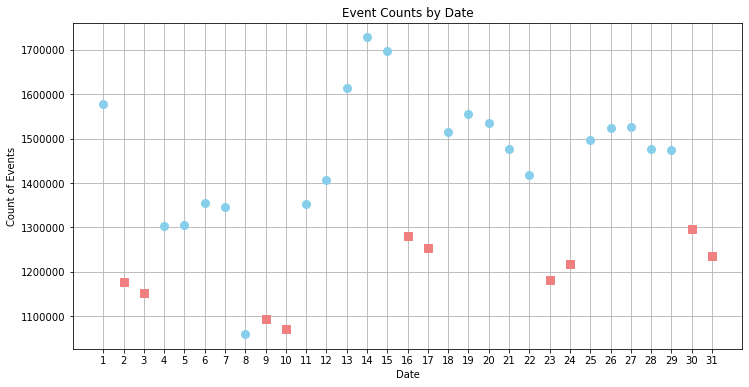

In [49]:
import calendar
import matplotlib.pyplot as plt

# Group by date and count the occurrences
events_count_by_day_df = users_in_march_df.groupBy('day_of_month').count()

# Collect the data for visualization
events_count_by_day_pd = events_count_by_day_df.toPandas()
events_count_by_day_pd.sort_values('day_of_month', inplace=True)

# Define weekend days in March 2023
weekend_days = [2, 3, 9, 10, 16, 17, 23, 24, 30, 31]



# Plotting with weekends highlighted
plt.figure(figsize=(12, 6))
for index, row in events_count_by_day_pd.iterrows():
    if row['day_of_month'] in weekend_days:
        plt.plot(row['day_of_month'], row['count'], marker='s', markersize=8, color='lightcoral', linestyle='-', linewidth=2)
    else:
        plt.plot(row['day_of_month'], row['count'], marker='o', markersize=8, color='skyblue', linestyle='-', linewidth=2)

plt.ticklabel_format(style='plain')
plt.xlabel('Date')
plt.ylabel('Count of Events')
plt.title('Event Counts by Date')
plt.xticks(range(1, 32))  # Assuming up to 31 days in a month
plt.grid(True)
plt.show()

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a font that supports more characters
plt.rcParams['font.family'] = 'Arial Unicode MS'


def analyze_and_visualize_category(df, category):
    # Group by the category and count distinct users
    category_count = df.groupBy(category).agg(F.countDistinct('profile_id').alias('user_count'))

    # Collect the data for local analysis
    category_count_pd = category_count.toPandas()

    # Sorting for better visualization
    category_count_pd.sort_values('user_count', ascending=False, inplace=True)

    # Visualization
    plt.figure(figsize=(12, 6))
    sns.barplot(x='user_count', y=category, data=category_count_pd, palette='viridis')
    plt.title(f'User Count by {category}')
    plt.xlabel('Number of Users')
    plt.ylabel(category.capitalize())
    plt.show()

# List of columns to analyze
columns_to_analyze = ['device_model', 'device_manufacturer', 'connection_type', 'country_iso_code', 'device_type', 'operator_name', 'os_name']



findfont: Font family ['Arial Unicode MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial Unicode MS'] not found. Falling back to DejaVu Sans.


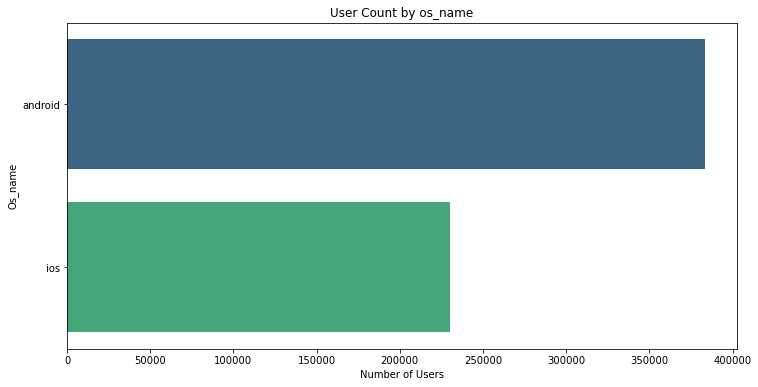

In [51]:
# Using the function for each category
analyze_and_visualize_category(users_in_march_df, 'os_name')

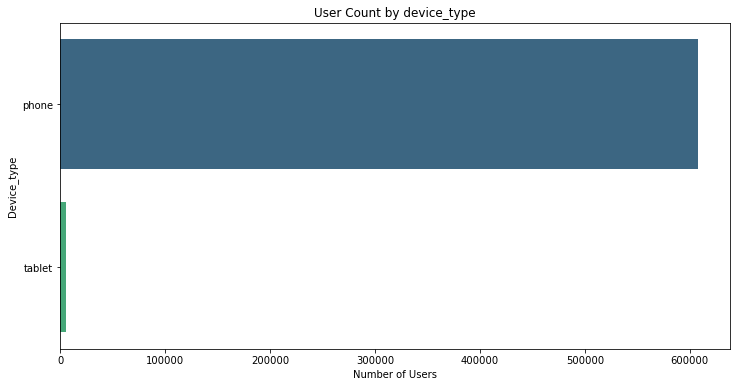

In [52]:
# Using the function for each category
analyze_and_visualize_category(users_in_march_df, 'device_type')

### 3.2. Events

In [53]:
sdf.select('event_json').distinct().count()


6367112

In [ ]:
events = sdf.select('event_json').distinct().collect()
events[:10]

In [55]:
event_names = sdf.select('event_name').distinct().collect()
len(event_names)

718

In [26]:
sdf.printSchema()

root
 |-- event_datetime: timestamp (nullable = true)
 |-- event_json: string (nullable = true)
 |-- event_name: string (nullable = true)
 |-- event_receive_datetime: string (nullable = true)
 |-- event_receive_timestamp: string (nullable = true)
 |-- event_timestamp: string (nullable = true)
 |-- session_id: string (nullable = true)
 |-- installation_id: string (nullable = true)
 |-- appmetrica_device_id: string (nullable = true)
 |-- city: string (nullable = true)
 |-- connection_type: string (nullable = true)
 |-- country_iso_code: string (nullable = true)
 |-- device_ipv6: string (nullable = true)
 |-- device_locale: string (nullable = true)
 |-- device_manufacturer: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- google_aid: string (nullable = true)
 |-- ios_ifa: string (nullable = true)
 |-- ios_ifv: string (nullable = true)
 |-- mcc: string (nullable = true)
 |-- mnc: string (nullable = true)
 |-- operator_name